In [1]:
import numpy as np

import tensorflow as tf
import sklearn
from sklearn import metrics

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Příprava vstupních dat
### Import datasetu

In [2]:
df = pd.read_csv('data.csv', sep=';')

### Preprocessing

In [3]:
# set gender as a category data type
df.Gender = df.Gender.map({0: 'female', 1: 'male'}).astype('category')

# drop ID columns
df = df.drop(['Unit1', 'Unit2', 'Gender'], axis=1)

### Normalizace

In [4]:
normalization = "mean"
if normalization == "mean":
    series_labels = df.pop('isSepsis')
    df = (df - df.mean()) / df.std()
    df['isSepsis'] = series_labels
elif normalization == "minmax":
    df = (df - df.min()) / (df.max() - df.min())

### Chybějící data

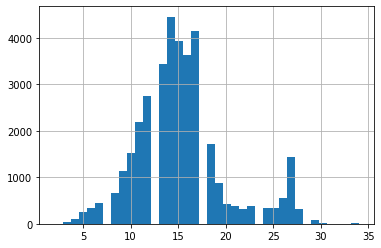

Before: number of rows = 36302, percentage of non-NA cells = 59.9589989242292


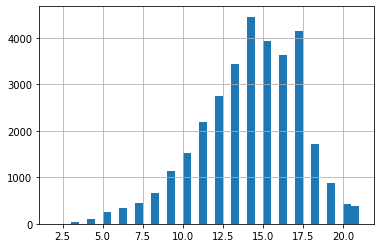

After: number of rows = 32488, percentage of non-NA cells = 63.22139996630335


In [5]:
# Drop 10% of rows with the most missing data.
df_row_null_sum = df.isnull().sum(axis=1)
df_row_null_sum.hist(bins=len(df.columns))
plt.show()
print(f"Before: number of rows = {len(df)}, percentage of non-NA cells = {df.count().sum() / df.size * 100}")

df = df[df_row_null_sum < df_row_null_sum.quantile(0.9)]
df.isnull().sum(axis=1).hist(bins=len(df.columns))
plt.show()
print(f"After: number of rows = {len(df)}, percentage of non-NA cells = {df.count().sum() / df.size * 100}")

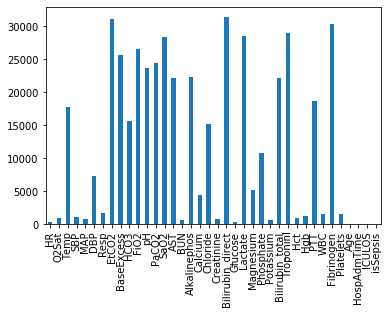

Before: number of columns = 38, percentage of non-NA cells = 63.22139996630335


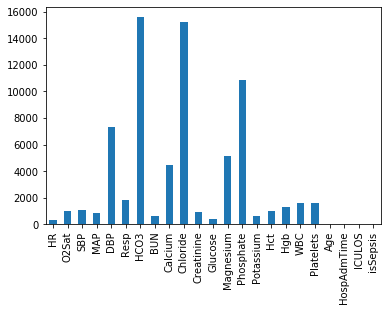

After: number of columns = 23, percentage of non-NA cells = 90.39043178484631


In [6]:
# Drop columns with more than 50% missing data.
df_col_null_sum = df.isnull().sum(axis=0)
df_col_null_sum.plot(kind='bar')
plt.show()
print(f"Before: number of columns = {len(df.columns)}, percentage of non-NA cells = {df.count().sum() / df.size * 100}")

df = df[df.columns[(df_col_null_sum / len(df)) < 0.5]]
df.isnull().sum(axis=0).plot(kind='bar')
plt.show()
print(f"After: number of columns = {len(df.columns)}, percentage of non-NA cells = {df.count().sum() / df.size * 100}")

In [7]:
# Fill the missing data with mean/median.
print(f"Before: percentage of non-NA cells = {df.count().sum() / df.size * 100}")
df = df.fillna(df.mean())
print(f"After: percentage of non-NA cells = {df.count().sum() / df.size * 100}")

Before: percentage of non-NA cells = 90.39043178484631
After: percentage of non-NA cells = 100.0


### Nevyváženost dat

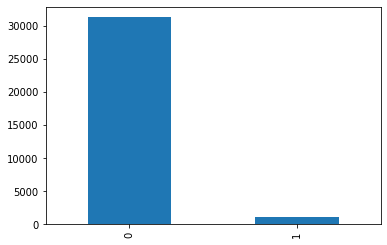

In [8]:
not_sepsis_cnt, sepsis_cnt = df['isSepsis'].value_counts()
df['isSepsis'].value_counts().plot(kind="bar")

# divide by class
not_sepsis = df[df['isSepsis'] == 0]
sepsis = df[df['isSepsis'] == 1]

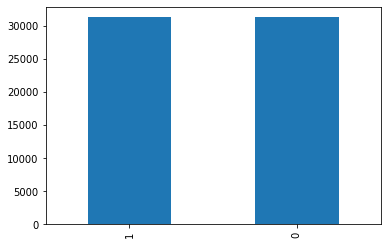

In [9]:
sampling = "over"
if sampling == "under":
    # random under-sampling
    not_sepsis_sample = not_sepsis.sample(sepsis_cnt)
    df = pd.concat([sepsis, not_sepsis_sample], axis=0, ignore_index=True)
elif sampling == "over":
    # random over-sampling
    sepsis_over = sepsis.sample(not_sepsis_cnt, replace=True)
    df = pd.concat([sepsis_over, not_sepsis], axis=0, ignore_index=True)

df['isSepsis'].value_counts().plot(kind="bar")

### Analýza dat

In [10]:
df.head()

,HR,O2Sat,SBP,MAP,DBP,Resp,HCO3,BUN,Calcium,Chloride,...,Phosphate,Potassium,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,isSepsis
0,-0.231447,0.196536,-1.347840,-0.785918,-0.622293,-0.406667,-0.000625,-1.034543,-0.649135,0.001420,...,-0.371784,0.322213,0.986725,0.513368,0.793351,1.031991,-1.681991,0.372584,0.220741,1
1,1.226806,-2.279340,0.492580,0.498106,-0.017324,1.286252,0.179312,0.275375,1.310678,-0.132438,...,0.164871,0.482300,0.934427,1.262193,1.139213,1.149693,-1.927517,0.375285,9.107256,1
2,0.769315,0.903929,-1.152972,-0.430397,-0.268456,-1.004169,0.661230,-0.215845,-0.196870,0.591108,...,-0.985103,0.802474,0.777532,1.112428,-0.316288,-0.733527,-0.145629,0.375358,1.804476,1
3,1.970230,0.903929,-0.373500,0.043631,0.014613,1.784170,-1.025483,-0.870804,-0.046115,0.410221,...,-0.371784,-0.798396,-0.007318,-0.006315,0.004258,-0.002317,0.707028,0.375431,2.156418,1
4,1.627111,0.196536,-0.027068,1.347208,1.854563,-0.406667,0.902189,-0.707064,0.180017,0.952881,...,0.011541,-0.478222,-1.262104,-0.006315,0.004258,-0.002317,-2.154811,0.375358,3.784145,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62638 entries, 0 to 62637
Data columns (total 23 columns):
HR             62638 non-null float64
O2Sat          62638 non-null float64
SBP            62638 non-null float64
MAP            62638 non-null float64
DBP            62638 non-null float64
Resp           62638 non-null float64
HCO3           62638 non-null float64
BUN            62638 non-null float64
Calcium        62638 non-null float64
Chloride       62638 non-null float64
Creatinine     62638 non-null float64
Glucose        62638 non-null float64
Magnesium      62638 non-null float64
Phosphate      62638 non-null float64
Potassium      62638 non-null float64
Hct            62638 non-null float64
Hgb            62638 non-null float64
WBC            62638 non-null float64
Platelets      62638 non-null float64
Age            62638 non-null float64
HospAdmTime    62638 non-null float64
ICULOS         62638 non-null float64
isSepsis       62638 non-null int64
dtypes: float64(22)

In [12]:
df.describe()

,HR,O2Sat,SBP,MAP,DBP,Resp,HCO3,BUN,Calcium,Chloride,...,Phosphate,Potassium,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,isSepsis
count,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,...,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000,62638.000000
mean,0.217942,-0.094213,-0.073830,-0.104320,-0.087346,0.166341,-0.033183,0.198815,-0.227998,-0.018797,...,0.035045,0.020015,-0.136967,-0.131238,0.127928,-0.037426,0.000539,-0.098671,0.735561,0.500000
std,1.076459,1.121805,0.999645,0.974067,0.877029,1.091235,0.816316,1.107579,1.331380,0.841479,...,0.899892,0.996976,0.908499,0.893042,1.166273,1.007386,0.992602,1.288656,1.971220,0.500004
min,-3.290921,-24.915918,-3.924427,-3.689339,-2.957614,-3.394173,-4.639869,-1.143703,-5.465751,-12.251840,...,-2.441738,-4.240268,-4.016485,-3.979585,-1.584447,-2.028240,-2.897467,-38.803839,-0.659112,0.000000
25%,-0.545973,-0.510857,-0.763236,-0.785918,-0.622293,-0.605834,-0.061647,-0.488744,-0.272248,-0.132438,...,-0.371784,-0.638309,-0.739121,-0.734675,-0.402753,-0.664868,-0.648836,-0.024841,-0.395156,0.000000
50%,0.140264,0.196536,-0.113676,-0.223009,-0.017324,-0.008333,-0.000625,-0.052105,-0.002127,0.001420,...,0.000052,0.002039,-0.076675,-0.035771,0.004258,-0.005010,0.126638,0.339368,-0.043215,0.500000
75%,0.912281,0.903929,0.492580,0.458406,0.226915,0.788335,-0.000625,0.439114,0.255394,0.229335,...,0.164871,0.482300,0.341712,0.313681,0.361024,0.296359,0.748962,0.375285,0.924624,1.000000
max,5.287042,0.903929,6.858267,12.368358,15.371121,8.157514,7.408084,9.717701,14.124836,6.017706,...,9.211338,12.328742,6.896441,9.599116,54.171318,20.727327,2.329081,0.550637,13.902454,1.000000


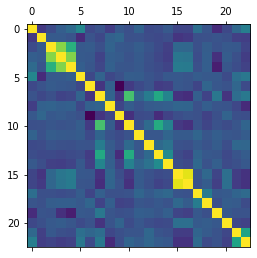

In [13]:
# measure the relationship and the dependency between two variables
plt.matshow(df.corr())

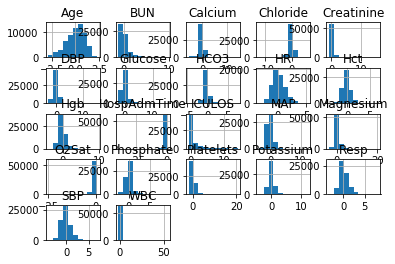

In [14]:
df.drop('isSepsis', 1).hist()
_ = plt.plot()

### Rozdělení dat na tréningová a testovací

In [15]:
df = df.reindex(np.random.permutation(df.index))

split_fraction = 0.8
train_fv = df.sample(frac=split_fraction)
test_fv = df.drop(train_fv.index)

print(f"velikost trenovacich dat = {len(train_fv)}, rozlozeni = {train_fv['isSepsis'].value_counts().values}")
print(f"velikost testovacich dat = {len(test_fv)}, rozlozeni = {test_fv['isSepsis'].value_counts().values}")

train_labels = train_fv.pop('isSepsis')
test_labels = test_fv.pop('isSepsis')

velikost trenovacich dat = 50110, rozlozeni = [25078 25032]
velikost testovacich dat = 12528, rozlozeni = [6287 6241]


## Tvorba modelu
### Definice vrstev NN

In [16]:
print(f"input_dim = {len(train_fv.columns)}")
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, activation='relu', input_dim=len(train_fv.columns)))
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

input_dim = 22


### Volba funkcí a hyperparametrů

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                460       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,731
Trainable params: 1,731
Non-trainable params: 0
_________________________________________________________________


### Tréning

In [18]:
history = model.fit(train_fv.values, train_labels.values,
                    validation_data=(test_fv.values, test_labels.values),
                    epochs=10, batch_size=32)

Train on 50110 samples, validate on 12528 samples
Epoch 1/10
50110/50110 [==============================] - 5s 108us/sample - loss: 0.4574 - accuracy: 0.7724 - val_loss: 0.4291 - val_accuracy: 0.7879
Epoch 2/10
50110/50110 [==============================] - 5s 106us/sample - loss: 0.4015 - accuracy: 0.8060 - val_loss: 0.4010 - val_accuracy: 0.8070
Epoch 3/10
50110/50110 [==============================] - 4s 82us/sample - loss: 0.3722 - accuracy: 0.8253 - val_loss: 0.3701 - val_accuracy: 0.8327
Epoch 4/10
50110/50110 [==============================] - 4s 75us/sample - loss: 0.3476 - accuracy: 0.8394 - val_loss: 0.3487 - val_accuracy: 0.8399
Epoch 5/10
50110/50110 [==============================] - 4s 85us/sample - loss: 0.3279 - accuracy: 0.8531 - val_loss: 0.3324 - val_accuracy: 0.8485
Epoch 6/10
50110/50110 [==============================] - 4s 80us/sample - loss: 0.3104 - accuracy: 0.8625 - val_loss: 0.3262 - val_accuracy: 0.8641
Epoch 7/10
50110/50110 [==============================

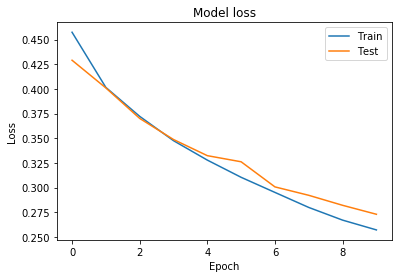

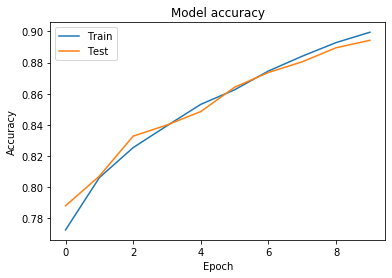

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

## Evaluace

In [20]:
metrics_values = model.evaluate(test_fv.values, test_labels.values, verbose=0)
true_labels = test_labels.values
pred_scores = model.predict(test_fv.values).flatten()
for i in range(len(model.metrics_names)):
    print(f"{model.metrics_names[i]} = {metrics_values[i]}")

loss = 0.2729678433554992
accuracy = 0.8943167328834534


### Metriky True Positive Rate, False Positive Rate, ROC křivka, AUC

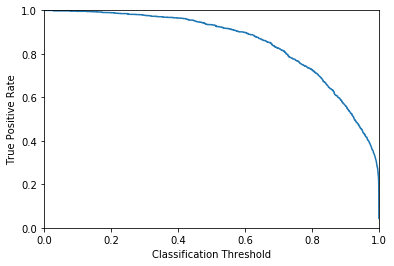

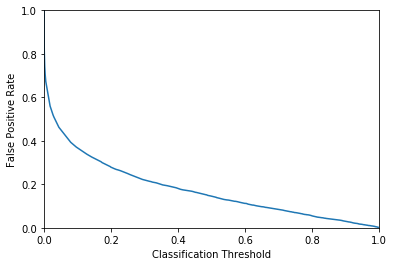

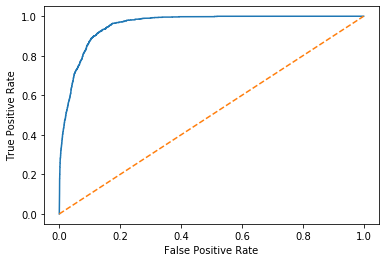

In [21]:
fprs, tprs, thresholds = metrics.roc_curve(true_labels, pred_scores)
plt.plot(thresholds, tprs)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('Classification Threshold')
plt.ylabel('True Positive Rate')
plt.show()

plt.plot(thresholds, fprs)
plt.xlabel('Classification Threshold')
plt.ylabel('False Positive Rate')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

# The ROC curve is created by plotting the true positive rate (TPR) against
# the false positive rate (FPR) at various threshold settings.
plt.plot(fprs, tprs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

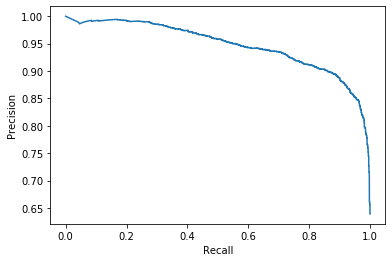

In [22]:
# Compute precision-recall pairs for different probability thresholds.
precisions, recalls, thresholds = metrics.precision_recall_curve(true_labels, pred_scores)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Klasifikace s využitím prahu

In [30]:
pred_threshold = 0.5
# convert prediction scores > threshold to 1 (positive), scores <= threshold to 0 (negative)
pred_labels = np.where(pred_scores > pred_threshold, 1, 0)

### Metriky True/False Positives/Negatives a matice záměn

Predicted,0,1
Actual,,
0,5374,913
1,411,5830


Predicted,0,1
Actual,,
0,85.477970,14.629066
1,6.537299,93.414517


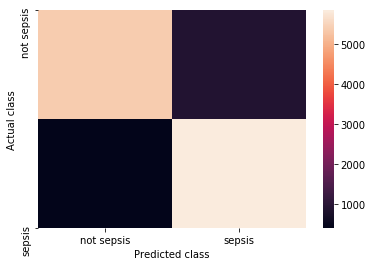

In [31]:
# true negatives  [0][0]  |  false positives is [0][1]
# false negatives [1][0]  |  true positives is [1][1]

df_confusion = pd.crosstab(pd.Series(true_labels, name='Actual'),
                           pd.Series(pred_labels, name='Predicted'),
                           margins=False)
# absolute
display(df_confusion)
# percentual
display(df_confusion / df_confusion.sum(axis=1) * 100)

cm = metrics.confusion_matrix(true_labels, pred_labels)
names = ['not sepsis', 'sepsis']
cm_df = pd.DataFrame(cm, index=names, columns=names)
hm = sns.heatmap(cm_df)
hm.set(xlabel='Predicted class', ylabel='Actual class')
plt.show()

### Metriky Accuracy, Precision, Recall, F1 score, AUC

In [32]:
# 90% accuracy may seem good, but classifier model that always predicts "benign" on class-imbalanced
# dataset can achieve the exact same accuracy (90/100 correct predictions).
accuracy = metrics.accuracy_score(true_labels, pred_labels)
# The precision is intuitively the ability of the classifier not to label as positive
# a sample that is negative. A model that produces no false positives has a precision of 1.0.
precision = metrics.precision_score(true_labels, pred_labels)
# The recall is intuitively the ability of the classifier to find all the positive samples.
# A model that produces no false negatives has a recall of 1.0.
recall = metrics.recall_score(true_labels, pred_labels)
# The F1 score can be interpreted as a weighted average of the precision and recall,
# where an F1 score reaches its best value at 1 and worst score at 0.
f1 = metrics.f1_score(true_labels, pred_labels)
# Area Under the ROC Curve.
auc = metrics.roc_auc_score(true_labels, pred_scores)

print(f"accuracy = {accuracy}\nprecision = {precision}\nrecall = {recall}\nF1 score = {f1}\nAUC = {auc}")

accuracy = 0.894316730523627
precision = 0.8646003262642741
recall = 0.9341451690434225
F1 score = 0.8980283425754776
AUC = 0.955771717667588
